Importer les bibliothèques suivantes :

In [1]:
import pandas as pd
import numpy as np

import zipfile as zf
import tarfile


import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator

from numba import jit

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# from functools import reduce
from urllib import request
import os

from PIL import Image
import io, bson, multiprocessing

Importer le fichier en local :

In [2]:
request.urlretrieve ("https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv", "en.openfoodfacts.org.products.csv")

('en.openfoodfacts.org.products.csv',
 <http.client.HTTPMessage at 0x7f325c2272d0>)

Lire le fichier csv importé, et l'affecter à une DataFrames :

In [3]:
df_food = pd.read_csv("en.openfoodfacts.org.products.csv", sep='\t')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,8,13,22,23,27,28,29,31,38,52,55,64,75,77) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Le nombre de lignes et de colonnnes du DataFrame

In [4]:
df_food.shape

(1982821, 186)

Afficher les 5 dernière lignes

In [5]:
df_food.tail(5)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,quantity,packaging,packaging_tags,packaging_text,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,origins_en,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,...,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
1982816,9999999910128,http://world-en.openfoodfacts.org/product/9999...,kiliweb,1572513866,2019-10-31T09:24:26Z,1572513866,2019-10-31T09:24:26Z,Sandwich club Rillette poisson combava,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:re,en:reunion,Réunion,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982817,999999999,http://world-en.openfoodfacts.org/product/9999...,nutrinet-sante,1608105503,2020-12-16T07:58:23Z,1608105504,2020-12-16T07:58:24Z,Thé noir BIO Darjeeling,NaN,NaN,NaN,NaN,NaN,NaN,Pagès,pages,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:france,en:france,France,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982818,9999999990397,http://world-en.openfoodfacts.org/product/9999...,kiliweb,1581171613,2020-02-08T14:20:13Z,1582644247,2020-02-25T15:24:07Z,Fati,NaN,NaN,440 g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:be,en:belgium,Belgium,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982819,9999999999994,http://world-en.openfoodfacts.org/product/9999...,kiliweb,1613129728,2021-02-12T11:35:28Z,1613129730,2021-02-12T11:35:30Z,Light & Free SKYR A BOIRE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:france,en:france,France,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982820,999999999999999,http://world-en.openfoodfacts.org/product/9999...,openfoodfacts-contributors,1587222660,2020-04-18T15:11:00Z,1605558295,2020-11-16T20:24:55Z,Signal Toothpaste,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Non food products, Open Beauty Facts, Toothpaste","en:non-food-products,en:open-beauty-facts,en:t...","Non food products,Open Beauty Facts,Toothpaste",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Créer un nouvelle DataFrame

In [6]:
df_food_drop = pd.DataFrame(df_food)

Supprimer les colonnes avec 80% de valeurs manquantes

In [7]:
index_names = (((df_food_drop.isna().sum()/df_food_drop.shape[0])*100))
df_food_drop.drop(index_names[index_names>80].index, inplace=True, axis=1)

In [8]:
df_food_drop.shape

(1982821, 57)

Conserver les produits vendus en france

In [9]:
df_food_fr = df_food_drop[df_food_drop['countries_en'] == 'France']

Conserver les produits avec le "Nutri-Score" et le "Groupe Nova" rensignés, et conserver les 21 colonnes qui nous intéressent

In [10]:
df_food_fr = pd.DataFrame(df_food_fr[df_food_fr['nutriscore_score'].notna()])
df_food_fr = pd.DataFrame(df_food_fr[df_food_fr['nova_group'].notna()])

df_food_fr = df_food_fr[['code', 'nova_group','image_small_url', 'categories', 'pnns_groups_1','pnns_groups_2', 'product_name', 'carbohydrates_100g', 
                         'energy-kcal_100g', 'energy_100g', 'sugars_100g', 'fat_100g','saturated-fat_100g', 'salt_100g','sodium_100g', 'fiber_100g', 
                         'proteins_100g', 'nutriscore_score', 'nutriscore_grade', 'ecoscore_score_fr', 'ecoscore_grade_fr']]
                         
# df_food_fr = df_food_fr.reset_index()
#df_food_fr['index'] = df_food_fr.index.values

Renomer les colonnes :

*   "energy-kcal_100g" en "energy_kcal_100g"
*   "saturated-fat_100g" en "saturated_fat_100g"



In [11]:
df_food_fr.rename(columns = {"energy-kcal_100g": "energy_kcal_100g", 
                     "saturated-fat_100g":"saturated_fat_100g"}, inplace=True)

Nous avons maintenant 128685 ligne et 21 colonnes

In [12]:
df_food_fr.shape

(131918, 21)

Arrondissez les valeurs des colonnes à deux décimales

In [13]:
pd.options.display.float_format = '{:.2f}'.format

Afficher diverses statistiques des données (Moyenne, Max, Min …etc) pour chaque colonne :

In [14]:
df_food_fr.describe()

,nova_group,carbohydrates_100g,energy_kcal_100g,sugars_100g,fat_100g,saturated_fat_100g,salt_100g,sodium_100g,fiber_100g,proteins_100g,nutriscore_score,ecoscore_score_fr
count,131918.00,131498.00,113828.00,131558.00,131558.00,131561.00,131599.00,131599.00,69610.00,131561.00,131918.00,94701.00
mean,3.38,27.35,282.50,13.26,14.27,5.62,1.07,0.43,2.63,8.67,8.97,47.94
std,0.97,530.05,4034.61,76.67,81.67,9.95,38.69,15.48,3.89,201.40,8.93,27.11
min,1.00,-0.50,0.00,-0.50,0.00,0.00,0.00,0.00,0.00,0.00,-15.00,-28.00
25%,3.00,3.20,113.00,0.90,1.50,0.30,0.09,0.04,0.50,2.00,1.00,28.00
50%,4.00,14.00,248.00,3.60,8.00,2.20,0.60,0.24,1.60,6.10,9.00,45.00
75%,4.00,50.00,396.00,18.24,22.00,8.00,1.26,0.50,3.40,11.30,16.00,69.00
max,4.00,192000.00,1360000.00,27000.00,29000.00,2000.00,14000.00,5600.00,100.00,73000.00,40.00,125.00


Convertir la colonne "energy_100g" en float

In [15]:
df_food_fr["energy_100g"] = df_food_fr["energy_100g"].apply(float)

Détecter et exclure les valeurs aberrantes dans la trame de données

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


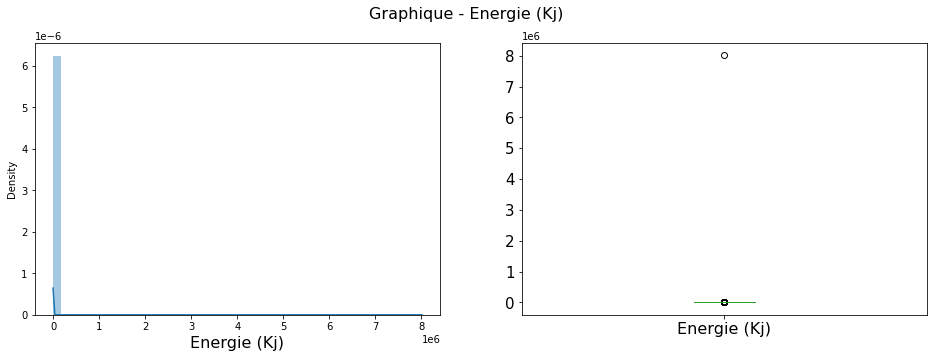

In [16]:
# Graph Nutriscore
plt.figure(1)

plt.subplot(121)
fig = sns.distplot(df_food_fr['energy_100g'])


plt.subplot(122)
ax = df_food_fr['energy_100g'].plot.box(figsize=(16,5))

ax.set_xticklabels(["Energie (Kj)"])

plt.suptitle('Graphique - Energie (Kj)',fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=15)
fig.set_xlabel('Energie (Kj)', fontsize=16)
plt.show()

Calculer le dernier centile

In [17]:
q = df_food_fr["energy_100g"].quantile(0.99)
q

3117.0

Supprimer les valeurs qui sont inférieur au dernier centile

In [18]:
df_food_fr = df_food_fr[df_food_fr["energy_100g"]<q]

Remplacer les 'nan' par 0

In [19]:
columns = ["sugars_100g", 'saturated_fat_100g', 'salt_100g', 'sodium_100g', 'fiber_100g', 'proteins_100g','carbohydrates_100g', 'fat_100g']
df_food_fr[columns] = df_food_fr[columns].fillna(value=0)

Pour les colonnes qui contiennent des valeurs nutritives pour 100g, nous conserverons les valeurs entre 0g et 100g.

In [20]:
filter = ((df_food_fr[columns] <= 100) & (df_food_fr[columns]>=0)).all(axis=1)
df_food_fr = df_food_fr[filter]

In [21]:
df_food_fr.shape

(130233, 21)

Afficher diverses statistiques aprés la suppression des valeurs aberrantes

In [22]:
df_food_fr.describe()

,nova_group,carbohydrates_100g,energy_kcal_100g,energy_100g,sugars_100g,fat_100g,saturated_fat_100g,salt_100g,sodium_100g,fiber_100g,proteins_100g,nutriscore_score,ecoscore_score_fr
count,130233.00,130233.00,112618.00,130233.00,130233.00,130233.00,130233.00,130233.00,130233.00,130233.00,130233.00,130233.00,93769.00
mean,3.40,26.09,263.72,1089.50,13.16,13.32,5.44,0.97,0.39,1.40,8.18,8.97,48.01
std,0.96,26.27,174.81,721.45,18.53,15.04,7.75,2.13,0.86,3.12,8.15,8.95,27.17
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-15.00,-28.00
25%,3.00,3.40,112.00,464.00,0.90,1.40,0.30,0.10,0.04,0.00,2.10,1.00,28.00
50%,4.00,14.00,245.00,1008.00,3.70,7.90,2.10,0.60,0.24,0.00,6.10,9.00,45.00
75%,4.00,50.00,392.00,1625.00,19.00,21.70,7.70,1.27,0.51,1.80,11.50,16.00,69.00
max,4.00,100.00,2733.00,3116.00,100.00,100.00,81.70,100.00,49.99,100.00,95.00,40.00,125.00


Afficher le taux des valeurs manquantes par colonne :

In [31]:
(df_food_fr.isna().sum()/df_food_fr.shape[0])*100

code                  0.00
nova_group            0.00
image_small_url       3.52
categories            0.00
pnns_groups_1         0.00
pnns_groups_2         0.00
product_name          0.19
carbohydrates_100g    0.00
energy_kcal_100g      0.00
energy_100g           0.00
sugars_100g           0.00
fat_100g              0.00
saturated_fat_100g    0.00
salt_100g             0.00
sodium_100g           0.00
fiber_100g            0.00
proteins_100g         0.00
nutriscore_score      0.00
nutriscore_grade      0.00
ecoscore_score_fr    28.00
ecoscore_grade_fr    28.00
dtype: float64

***Remarque*** : 

Nous constatons que le taux de valeurs manquantes de la colonne «energy-kcal_100g » est de 13.87 %.
En effet la colonne «energy_100g » a un taux de valeurs manquantes de 0%, en sachant que  1 kJ = 0,2388 kcal, nous recalculons les valeurs de cette colonne pour éviter toutes incohérences : 


In [24]:
df_food_fr['energy_kcal_100g'] = np.around(df_food_fr['energy_100g']*0.2388)

Afficher les catégories des aliments

In [30]:
df_food_fr['pnns_groups_2'].unique()

array(['Bread', 'One-dish meals', 'Dairy desserts', 'Fruits', 'Sweets',
       'unknown', 'Sweetened beverages', 'Dressings and sauces',
       'Fish and seafood', 'Cheese', 'Biscuits and cakes', 'Appetizers',
       'Vegetables', 'Meat', 'Salty and fatty products', 'Sandwiches',
       'Legumes', 'Unsweetened beverages', 'Pizza pies and quiches',
       'Breakfast cereals', 'Dried fruits', 'Processed meat', 'Pastries',
       'Cereals', 'Soups', 'Milk and yogurt', 'Chocolate products',
       'Plant-based milk substitutes', 'Artificially sweetened beverages',
       'Waters and flavored waters', 'Nuts', 'Fats', 'Fruit juices',
       'Teas and herbal teas and coffees', 'Ice cream', 'Potatoes',
       'Offals', 'Alcoholic beverages', 'Eggs', 'Fruit nectars'],
      dtype=object)

Afficher le taux des valeurs manquantes par colonne :

In [26]:
(df_food_fr.isna().sum()/df_food_fr.shape[0])*100

code                  0.00
nova_group            0.00
image_small_url       3.52
categories            0.00
pnns_groups_1         0.00
pnns_groups_2         0.00
product_name          0.19
carbohydrates_100g    0.00
energy_kcal_100g      0.00
energy_100g           0.00
sugars_100g           0.00
fat_100g              0.00
saturated_fat_100g    0.00
salt_100g             0.00
sodium_100g           0.00
fiber_100g            0.00
proteins_100g         0.00
nutriscore_score      0.00
nutriscore_grade      0.00
ecoscore_score_fr    28.00
ecoscore_grade_fr    28.00
dtype: float64

Générer un fichier csv de la DataFrame "df_food_fr" :

In [27]:
df_food_fr.to_csv('df_food_fr.csv')